In [ ]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
dataset = datasets.MNIST('.', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F77BB660ED0>, 5)

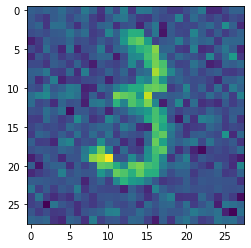

In [ ]:
import matplotlib.pyplot as plt
noized = dataset.data[1234].float() / 255 + torch.normal(
    torch.zeros_like(dataset.data[1234].float()), 
    0.2 * torch.ones_like(dataset.data[1234].float()))
plt.imshow(noized.detach().numpy())
plt.show()

In [ ]:
# hyperparams
in_chan = 1
#TODO change model h_params
hidden_ch = 64
out_ch = 1
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128
noise_factor = 0.4

In [ ]:
class Encoder(nn.Module):
  #28x28 -> 14x14 -> 7x7 
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    #TODO modify architecture as you wish. Add more layers, make hidden smaller, etc
    self.conv1 = nn.Conv2d(in_chan, hidden_ch, kernel_size=5, stride=1, padding=2)
    self.pool1 = nn.MaxPool2d(2, 2) # 14 x 14
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(2, 2) # 7 x 7
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, out_ch, kernel_size=3, stride=1, padding=1)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.do1(self.activ(self.pool1(self.conv1(x))))
    x = self.do2(self.activ(self.pool2(self.conv2(x))))
    x = self.conv3(x)

    return x

class Decoder(nn.Module):
  #hidden_out-> hidden -> 28*28 
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    #TODO modify architecture as you wish. Add more layers, make hidden smaller, etc
    self.conv1 = nn.Conv2d(out_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2) # 14 x 14
    self.do1 = nn.Dropout(0.1)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, stride=1, padding=1)
    self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2) # 28 x 28
    self.do2 = nn.Dropout(0.1)
    self.conv3 = nn.Conv2d(hidden_ch, in_chan, kernel_size=5, stride=1, padding=2)
    self.activ = nn.ReLU()

  def forward(self, x):
    x = self.do1(self.activ(self.upsample1(self.conv1(x))))
    x = self.do2(self.activ(self.upsample2(self.conv2(x))))
    x = self.conv3(x)

    return x

class ConvAutoEncoder(nn.Module):
  def __init__(self, in_chan, hidden_ch, out_ch):
    super().__init__()
    self.encoder = Encoder(in_chan, hidden_ch, out_ch)
    self.decoder = Decoder(in_chan, hidden_ch, out_ch)

  def forward(self, x):
    hidden = self.encoder(x)
    x_ = self.decoder(hidden)

    return x_


In [ ]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

In [ ]:
model_conv = ConvAutoEncoder(in_chan, hidden_ch, out_ch).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.MSELoss()

epoch: 0, step: 0, loss: 0.022711174562573433
epoch: 0, step: 200, loss: 0.012126731686294079
epoch: 0, step: 400, loss: 0.011887522414326668


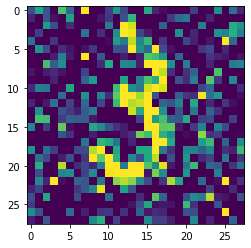

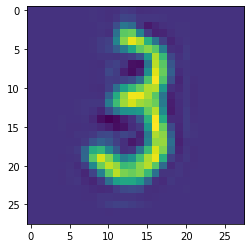

epoch: 1, step: 0, loss: 0.012067449279129505
epoch: 1, step: 200, loss: 0.011783723719418049
epoch: 1, step: 400, loss: 0.012146242894232273


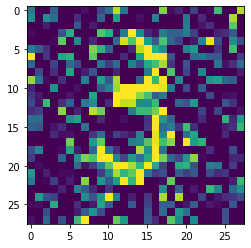

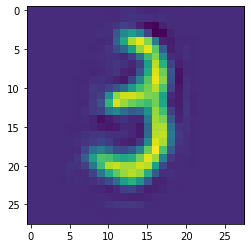

epoch: 2, step: 0, loss: 0.01234004832804203
epoch: 2, step: 200, loss: 0.011367874220013618
epoch: 2, step: 400, loss: 0.01166075561195612


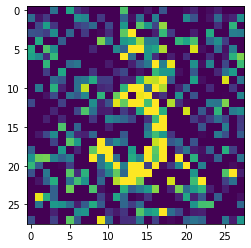

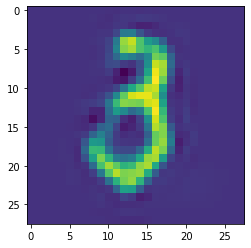

epoch: 3, step: 0, loss: 0.0109945647418499
epoch: 3, step: 200, loss: 0.011755614541471004
epoch: 3, step: 400, loss: 0.012100815773010254


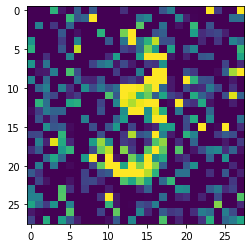

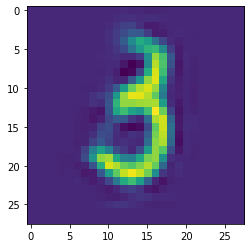

epoch: 4, step: 0, loss: 0.011537094600498676
epoch: 4, step: 200, loss: 0.011366404592990875
epoch: 4, step: 400, loss: 0.011860276572406292


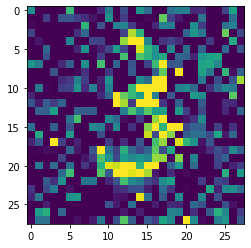

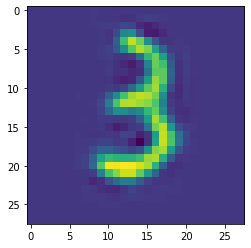

epoch: 5, step: 0, loss: 0.012146811932325363
epoch: 5, step: 200, loss: 0.011577379889786243
epoch: 5, step: 400, loss: 0.011615917086601257


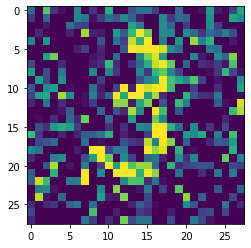

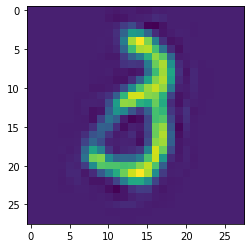

epoch: 6, step: 0, loss: 0.011397835798561573
epoch: 6, step: 200, loss: 0.010920779779553413
epoch: 6, step: 400, loss: 0.011960622854530811


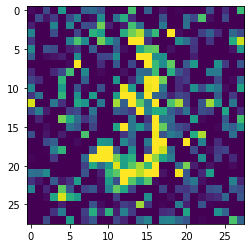

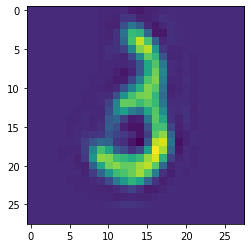

epoch: 7, step: 0, loss: 0.011780095286667347
epoch: 7, step: 200, loss: 0.011481369845569134
epoch: 7, step: 400, loss: 0.011595288291573524


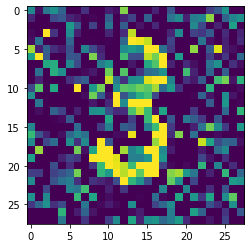

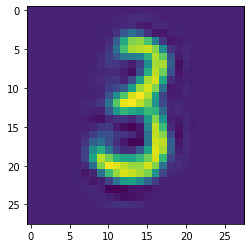

epoch: 8, step: 0, loss: 0.011599628254771233
epoch: 8, step: 200, loss: 0.011610222980380058
epoch: 8, step: 400, loss: 0.011380390264093876


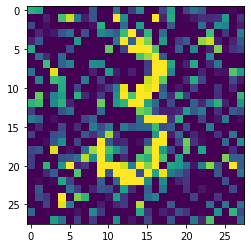

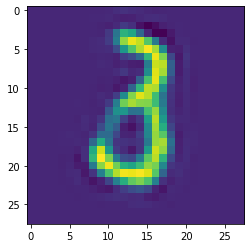

epoch: 9, step: 0, loss: 0.011139358393847942
epoch: 9, step: 200, loss: 0.011386259458959103
epoch: 9, step: 400, loss: 0.011576995253562927


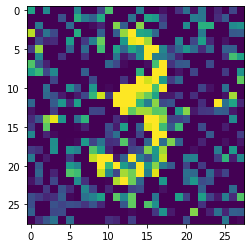

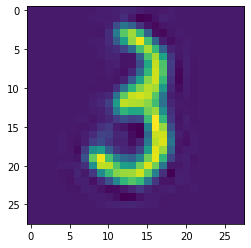

In [ ]:
for epoch in range(n_epochs):
  dataloader = DataLoader(dataset, 
                          batch_size, 
                          shuffle=True, 
                          collate_fn=collate_fn_conv,
                          drop_last = True,
                          )
  for i, batch in enumerate(dataloader):
    optim.zero_grad()
    data = batch['data'].to(device)
    noized = torch.clamp(data + 
                         torch.normal(torch.zeros_like(data), 
                                      noise_factor * torch.ones_like(data)), 0., 1.)
    predict = model_conv(noized)
    loss = loss_func(predict, data)
    loss.backward()
    optim.step()
    if i % 200 == 0:
      print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
  item = dataset.data[1234].unsqueeze(0).unsqueeze(0).float()/255
  item = torch.clamp(item + 
                     torch.normal(torch.zeros_like(item), 
                                  noise_factor * torch.ones_like(item)), 0., 1.)
  plt.imshow(item.squeeze().cpu().detach().numpy())
  plt.show()
  plt.imshow(model_conv(item.to(device)).squeeze().cpu().detach().numpy())
  plt.show()
  torch.save(model_conv.state_dict(), f'./conv_ae_chkpt_conv_{epoch}.pth')